# Imports and Setup

First we will, pretty obviously, import that Jupyter functions from `nanslice`. We are also going to use `urllib` and `tarfile` to get some example data from https://peerj.com/articles/2632. The data is a group template T2-weighted image, the difference in group average quantitative T1, the p-value for a two group comparison between control and treated animals, and a brain mask.

*Important* - The `%matplotlib notebook` magic is required if you want to use the interactive three-plane viewer. If you are only making static plots you do not need it.

In [1]:
%matplotlib notebook
import urllib.request
import tarfile

url = 'file:///Users/Tobias/Data/Agilent/nanslice_example.tar.gz'
urllib.request.urlretrieve(url, 'nanslice_example.tar.gz')
tgz = tarfile.open('nanslice_example.tar.gz')
tgz.extractall()
tgz.close()
data_dir = 'nanslice_example/'

# import sys
# !{sys.executable} -m pip install nanslice
import nanslice.jupyter as ns

/Users/Tobias/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Basic Slicing

The files are now contained in the `data_dir` directory. `nanslice` provides a simple `three_plane` function to give a quick view through an image, and an interactive `three_plane_viewer`. For convenience you can pass these functions a file name instead of loading the file first.

*Note* If you "Run All" cells in this notebook, you will have to run the interactive viewer cell again to enable the sliders. This is because the interactive viewer requires a call to `matplotlib.pyplot.ion()`. The non-interactive plots require a call to `matplotlib.pyplot.ioff()`, otherwise extra white-space is shown. Calling this in later cells turns off the sliders.

<IPython.core.display.Javascript object>


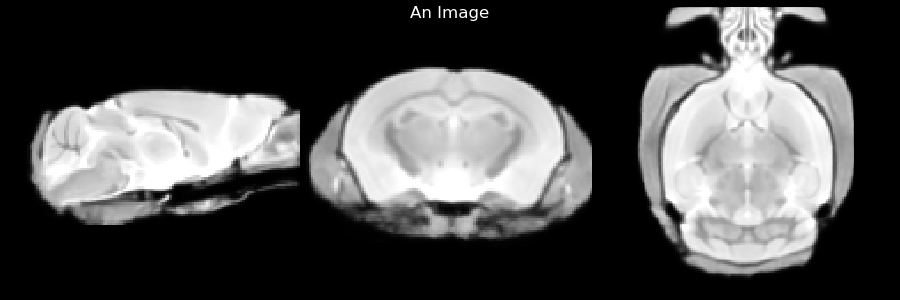

In [2]:
ns.three_plane(data_dir + 'template_T2w.nii.gz', title='An Image')

<IPython.core.display.Javascript object>


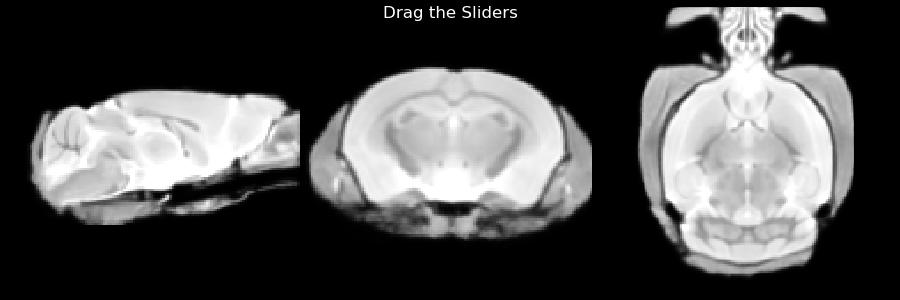

In [3]:
ns.three_plane(data_dir + 'template_T2w.nii.gz', interactive=True, title='Drag the Sliders')

However, if you are going to use the same image multiple times, e.g. a structural template image, then it makes sense to load it first

# Masking and Colormaps

The above examples are the fatest way to display an image in `nanslice`. However, if we want to have a more advanced plot or use overlays, then we need to use a `Layer` object. Here, we add a mask to the base image. The bounding box of the slices will be automatically cropped to the mask, making better use of the space in the plot.

<IPython.core.display.Javascript object>


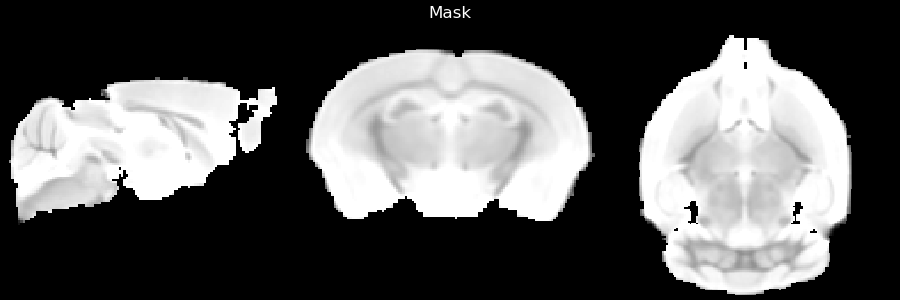

In [4]:
base = ns.Layer(data_dir + 'template_T2w.nii.gz', mask=data_dir + 'study_mask.nii.gz')
ns.three_plane(base, title='Mask')

Now that we have a `Layer` object, we can re-use it for future plots without having to reload the image from disk. For example, we can change the colormap (this can also be specified when creating the `Layer`). We can also add a colormap to the plot.

<IPython.core.display.Javascript object>


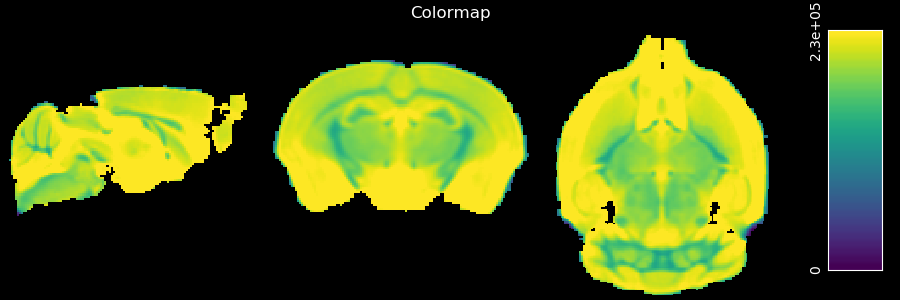

In [5]:
base.cmap = 'viridis'
ns.three_plane(base, cbar=True, title='Colormap')

# Overlays

Now we are ready to start adding overlays to images. First we will add a standard single-coded statistical overlay, in this case a p-value thresholded at p < 0.05. Because this p-value was generated with FSL randomise, it is stored as 1-p so we threshold at (1 - p) > 0.95. We also add a colorbar, and specify that we want to take it from layer 1 (Python arrays count from 0, so this is the 1st overlay). Note that the colorbar has been automatically labelled using the `label` property of the `Layer`.

<IPython.core.display.Javascript object>


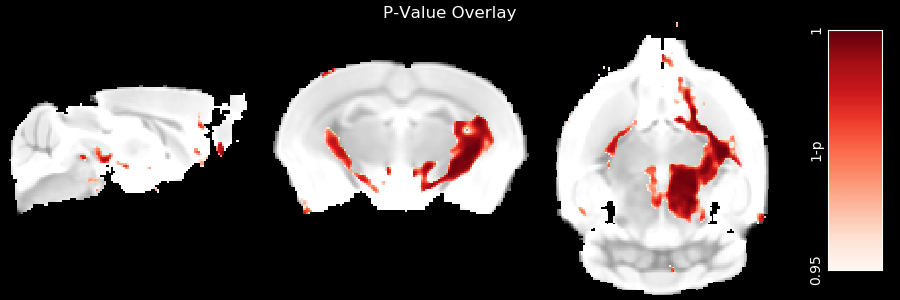

In [6]:
base.cmap = 'gist_gray'
pval = ns.Layer(data_dir + 'T1_tfce_p_tstat1.nii.gz', cmap='Reds', clim=(0.95,1.0), label='1-p', mask_threshold=0.95)
ns.three_plane([base, pval],cbar=1, title='P-Value Overlay')

One of the key reasons `nanslice` was written was to demonstrate dual-coded overlays, where both color and transparency have meaning - see https://www.cell.com/neuron/fulltext/S0896-6273(12)00428-X. To create a dual-coded overlay we specify an 'alpha' or transparency image when creating the `Layer`. In this case we will encode the difference in group T1 (essentially effect-size) as color and the p-value (significance) as transparency. Areas of strong color are hence interesting regions, but we will also be able to see areas with a large effect but low significance which normally would be hidden with a simply thresholded single-coded statistical overlay. Note that now the colorbar has become an 'alphabar', with two meaningful axes. Traditional significance levels can be indicated with a contour. Using this method we see that there are there several areas of T1 change that appear anatomically plausible but do not meet the traditional level of significance after multiple comparisons correction.

In [7]:
dual = ns.Layer(data_dir + 'T1_difference.nii.gz',
                cmap='RdYlBu_r', clim=(-100, 100), scale=1000, label='T1 Difference (ms)',
                alpha=data_dir + 'T1_tfce_p_tstat1.nii.gz', alpha_lim=(0.5, 1.0), alpha_label='1-p')
ns.three_plane([base, dual], cbar=1, contour=0.95, title='All the Bells & Whistles')

# Controlling Slices

The above examples all use the `three_plane` function. We can get better control of which slices are shown using the `slice_axis` and `slices` function. `slice_axis` is a thin wrapper that specifies a set of slices along one axis, while `slices` allows full control over which slices are drawn.

<IPython.core.display.Javascript object>


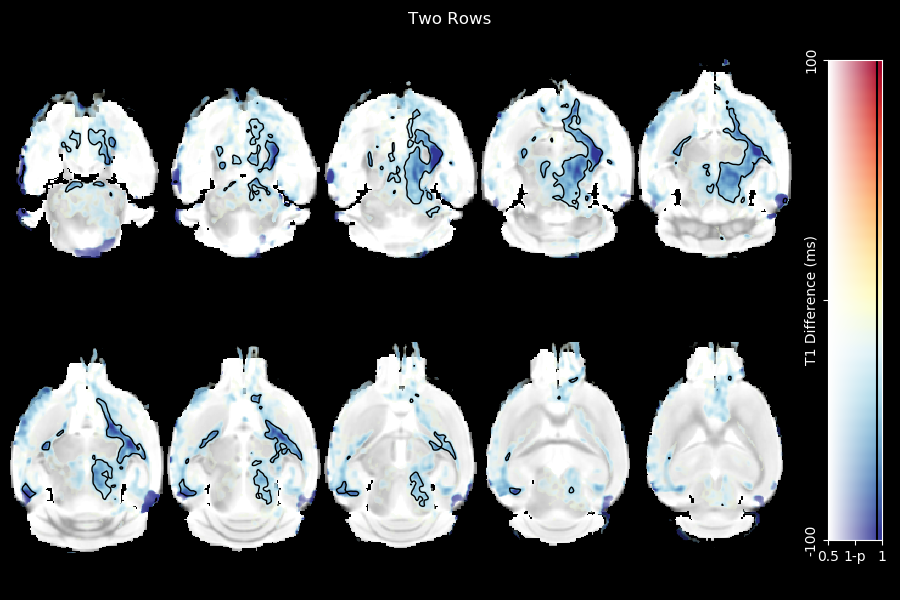

In [8]:
ns.slice_axis([base, dual], nrows=2, ncols=5,
              slice_axis='z', slice_lims=(0.3, 0.75),
              cbar=1, contour=0.95, title='Two Rows')

<IPython.core.display.Javascript object>


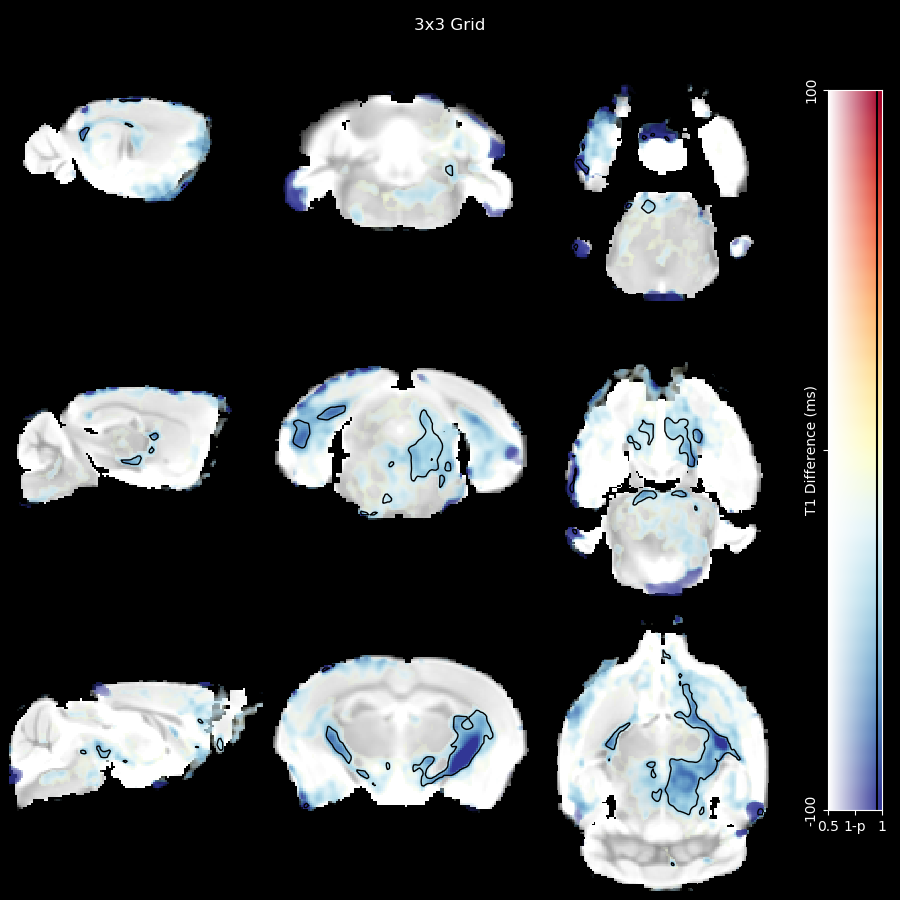

In [9]:
slice_ax = ['x','y','z','x','y','z','x','y','z']
slice_pos = [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5]
ns.slices([base, dual], nrows=3, ncols=3,
          slice_axes=slice_ax, slice_pos=slice_pos,
          cbar=1, contour=0.95, title='3x3 Grid')